In [1]:
# # Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout 

import pandas as pd
import numpy as np
import re
import collections

In [3]:
df = pd.read_csv('text_dataset - Sheet1 (1).csv')
df.head()

,Category,Descript
0,complaint,The give me a room which was so smelly and the...
1,meaningless,Unfortunately there was a mix up with my Passp...
2,comment,The (basic) room was comfortable and not too s...
3,comment,"Our primary concierge, [name[, was amazing in ..."
4,complaint,We booked through Priceline (paying more than ...


In [4]:
df = df.reindex(np.random.permutation(df.index))  
df = df[['Category', 'Descript']]
df.head()

,Category,Descript
4681,complaint,"What a load of crap, have to watch an ad each ..."
5617,comment,This is a great game that my mother and I enjo...
1905,complaint,"You can install it, but you can't import ebooks."
464,complaint,I hate it.
807,comment,would recommend a second time.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
#pip3 install nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91983\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<AxesSubplot:xlabel='Category', ylabel='count'>

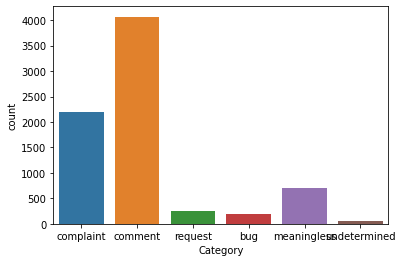

In [6]:
sns.countplot(x='Category', data=df)

In [7]:
NB_WORDS = 5016 # Parameter indicating the number of words we'll put in the dictionary 
# VAL_SIZE = 1000 # Size of the validation set 
EPOCHS = 20 # Number of epochs we usually start to train with 
BATCH_SIZE = 64 # Size of the batches used in the mini-batch gradient descent

In [8]:
def remove_stopwords(input_text):
  stopwords_list = stopwords.words('english')
  # Some words which might indicate a certain sentiment are kept via a whitelist
  whitelist = ["n't", "not", "no","yes"]
  words = input_text.split() 
  clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
  return " ".join(clean_words) 
    
def remove_mentions(input_text):
  return re.sub(r'@\w+', '', input_text)
       
df.Descript = df.Descript.apply(remove_stopwords).apply(remove_mentions)
df.head()

,Category,Descript
4681,complaint,"What load crap, watch ad time crashes."
5617,comment,This great game mother enjoy together.
1905,complaint,"You install it, can't import ebooks."
464,complaint,hate it.
807,comment,would recommend second time.


In [9]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.Descript, df.Category, test_size=0.2, random_state=37)
print('Training Data:', X_train.shape[0])
print('Test Data:', X_test.shape[0])

Training Data: 5957
Test Data: 1490


In [11]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Top 5 most common words are: [('the', 751), ('hotel', 600), ('not', 593), ('room', 445), ('it', 355)]


In [12]:
word_index = tk.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5016 unique tokens.


In [13]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [14]:
#X_train_seq 

In [15]:
#X_test_seq

In [16]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    5957.000000
mean        6.910693
std         4.748024
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        59.000000
Name: Descript, dtype: float64

In [17]:
def Findmaxlen(data):
    l=0
    for i in data:
        l=max(l,len(i))
    return l;

In [18]:
MAX_LEN = max(Findmaxlen(X_train_seq),Findmaxlen(X_train_seq))
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)
MAX_LEN

60

In [19]:
#X_train_seq_trunc

In [20]:
#X_test_seq_trunc

In [21]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [22]:
y_train_le

array([1, 3, 2, ..., 1, 1, 2])

In [23]:
#y_test_le

In [24]:
#y_train_oh

In [25]:
y_test_oh

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [26]:
from keras import models
from keras import layers

In [27]:
model=Sequential()

model.add(layers.Embedding(NB_WORDS, 120, input_length=MAX_LEN))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))

# Applying Dense Layer
model.add(Dense(1000,activation='relu'))
model.add(Dense(500,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(10,activation='relu'))

# Getting the last layer as an output...
model.add(layers.Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 120)           600960    
                                                                 
 spatial_dropout1d (SpatialD  (None, 60, 120)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 1000)              177000    
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 100)               50100     
                                                        

In [28]:
history = model.fit(X_train_seq_trunc, y_train_oh, epochs=20, batch_size=BATCH_SIZE, validation_data=(X_test_seq_trunc, y_test_oh))

Epoch 1/20
94/94 [==============================] - 59s 533ms/step - loss: 1.1618 - accuracy: 0.5491 - val_loss: 0.9590 - val_accuracy: 0.6517
Epoch 2/20
94/94 [==============================] - 43s 461ms/step - loss: 0.8009 - accuracy: 0.7067 - val_loss: 0.7303 - val_accuracy: 0.7477
Epoch 3/20
94/94 [==============================] - 43s 459ms/step - loss: 0.5549 - accuracy: 0.8056 - val_loss: 0.6090 - val_accuracy: 0.7846
Epoch 4/20
94/94 [==============================] - 41s 441ms/step - loss: 0.4299 - accuracy: 0.8435 - val_loss: 0.5759 - val_accuracy: 0.8101
Epoch 5/20
94/94 [==============================] - 42s 446ms/step - loss: 0.3492 - accuracy: 0.8692 - val_loss: 0.5604 - val_accuracy: 0.8201
Epoch 6/20
94/94 [==============================] - 42s 448ms/step - loss: 0.3109 - accuracy: 0.8795 - val_loss: 0.4799 - val_accuracy: 0.8302
Epoch 7/20
94/94 [==============================] - 48s 516ms/step - loss: 0.2683 - accuracy: 0.8942 - val_loss: 0.4688 - val_accuracy: 0.8604

In [29]:
test_model = model.evaluate(X_test_seq_trunc, y_test_oh)

47/47 [==============================] - 4s 91ms/step - loss: 0.5288 - accuracy: 0.8819


In [30]:
pr=model.predict(X_test_seq_trunc)

In [31]:
pr

array([[3.6360034e-05, 3.0788532e-04, 9.5073496e-08, 9.9965465e-01,
        8.7506629e-07, 2.9971496e-08],
       [9.5252814e-03, 6.3307357e-01, 3.6649071e-02, 2.9815587e-01,
        1.7564703e-02, 5.0314595e-03],
       [2.6958154e-27, 1.0000000e+00, 7.7911615e-15, 5.2375823e-13,
        8.2207816e-25, 5.3304977e-34],
       ...,
       [4.1219014e-06, 3.4011948e-05, 9.9986708e-01, 6.0422292e-12,
        9.4766852e-05, 2.7847187e-09],
       [1.6181714e-04, 8.9109102e-07, 9.6711171e-01, 2.3611165e-12,
        3.2725420e-02, 8.7559471e-08],
       [5.2753525e-27, 1.0000000e+00, 4.6090855e-13, 4.8486347e-15,
        9.7321159e-25, 1.7652300e-34]], dtype=float32)

In [32]:
print('Test accuracy is {0:.2f}%'.format(test_model[1] * 100))

Test accuracy is 88.19%
